<!--NAVIGATION-->
<a href="https://colab.research.google.com/github/masdeseiscaracteres/ml_course/blob/master/exercises/04_classification_and_regression_trees.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir en Google Colab" title="Abrir y ejecutar en Google Colab"/></a>

# Árboles de clasificación y regresión

Vamos a analizar el funcionamiento de los [árboles de clasificación y regresión](http://scikit-learn.org/stable/modules/tree.html) mediante ejemplos sencillos. Este notebook consta de las siguientes secciones:

1. Árboles de clasificación sobre ejemplos sintéticos
2. Árboles de clasificación sobre ejemplo realista
3. Árboles de regresión sobre ejemplo sintético

## 0. Configuración del entorno

En primer lugar, cargaremos las bibliotecas necesarias. También descargaremos los conjuntos de datos sobre los que vamos a trabajar.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

import requests
import os
def download_if_missing(url, filename):
    if not os.path.exists(filename):
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        r = requests.get(url, allow_redirects=True)
        with open(filename, 'wb') as f:
          f.write(r.content)

download_if_missing("https://github.com/masdeseiscaracteres/ml_course/raw/master/exercises/data/ex2data1.txt", "./data/ex2data1.txt")
download_if_missing("https://github.com/masdeseiscaracteres/ml_course/raw/master/exercises/data/ex2data2.txt", "./data/ex2data2.txt")
download_if_missing("https://raw.githubusercontent.com/susanli2016/Machine-Learning-with-Python/master/fruit_data_with_colors.txt", "./data/fruit_data_with_colors.txt")

In [2]:
# definimos una función para representar el resultado del ajuste
def plot_decision_boundary(X, y, h, model):
    
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .05  # step size in the mesh
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    model = model.fit(X, y)
    Zd = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Zd = Zd.reshape(xx.shape)
    
    Zp = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1] 
    Zp = Zp.reshape(xx.shape)
    
    # Error de clasificación
    ypred = model.predict(X)
    acc = accuracy_score(y, ypred)
    
    plt.figure(1, figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.contour(xx, yy, Zd, levels=[0], linewidths=2)
    plt.contourf(xx, yy, Zd, cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'FRONTERA DECISION\n Accuracy: %0.2g' % acc
    plt.title(msg)
    
    plt.subplot(1, 2, 2)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.axis([x_min, x_max, y_min, y_max])
    plt.contour(xx, yy, Zp, levels=[0], linewidths=2)
    plt.contourf(xx, yy, Zp,cmap=cm, alpha=.5)
    plt.xlabel("$x_1$", fontsize=16)
    plt.ylabel("$x_2$", fontsize=16)
    msg = 'PROBABILIDAD\n Accuracy: %0.2g' % acc
    plt.title(msg)
    
    plt.tight_layout()
    plt.show()

## 1. Ejemplos sintéticos en clasificación


In [3]:
# ejemplo1
ejemplo1 = pd.read_csv("./data/ex2data1.txt", sep=",", header=None, names=['x1', 'x2','label'])

# ejemplo2
ejemplo2 = pd.read_csv("./data/ex2data2.txt", sep=",", header=None, names=['x1', 'x2','label'])

# ejemplo 3: Problema XOR 
np.random.seed(0)

# -- parameters
N     = 800
mu    = 1.5      # Cambia este valor
sigma = 1      # Cambia este valor

# variables auxiliares
unos = np.ones(int(N/4))
random4 = sigma*np.random.randn(int(N/4), 1)
random2 = sigma*np.random.randn(int(N/2), 1)

# -- features
y3 = np.concatenate([-1*unos,       unos,          unos,         -1*unos]) 
X1 = np.concatenate([-mu + random4, mu + random4, -mu + random4, mu + random4])
X2 = np.concatenate([+mu + random2,               -mu + random2])
X3 = np.hstack((X1, X2))

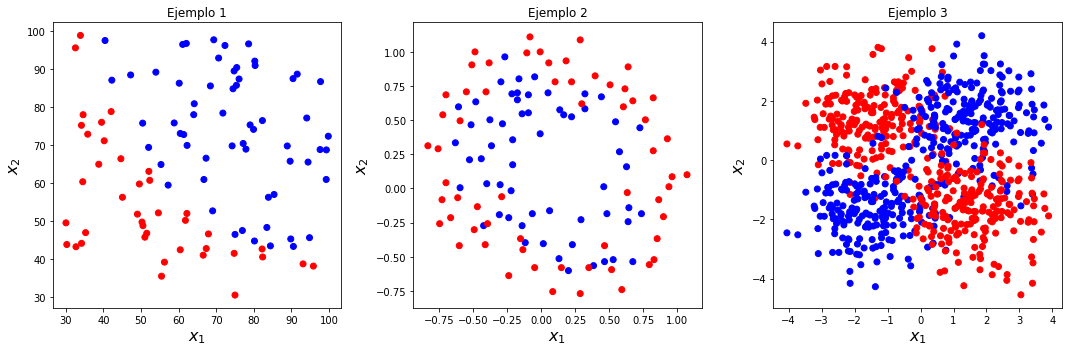

In [4]:
# dibujamos los conjuntos de datos
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.scatter(ejemplo1['x1'], ejemplo1['x2'], c=ejemplo1['label'], cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Ejemplo 1')

plt.subplot(1,3,2)
plt.scatter(ejemplo2['x1'], ejemplo2['x2'], c=ejemplo2['label'], cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Ejemplo 2')

plt.subplot(1,3,3)
plt.scatter(X3[:,0], X3[:,1], c=y3, cmap=cm_bright)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$x_2$", fontsize=16)
plt.title('Ejemplo 3')

plt.tight_layout()
plt.show()

### Ejemplo 1

Vamos a entrenar un árbol de decisión sobre el ejemplo 1.

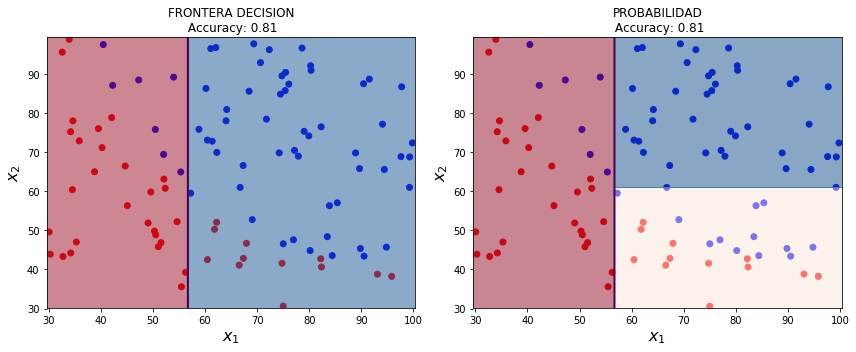

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# preparamos los datos
data1 = ejemplo1.values
X1 = data1[:,0:2]
y1 = data1[:,-1]

# creamos el modelo y ajustamos
tree_model_1 = DecisionTreeClassifier(min_samples_leaf=25)
tree_model_1.fit(X1, y1)

plot_decision_boundary(X1, y1, 0.05, tree_model_1)

#### Ejercicio
Entrena un árbol de decisión sobre los ejemplos 2 y 3. Visualiza el resultado y coméntalo.

#### Solución

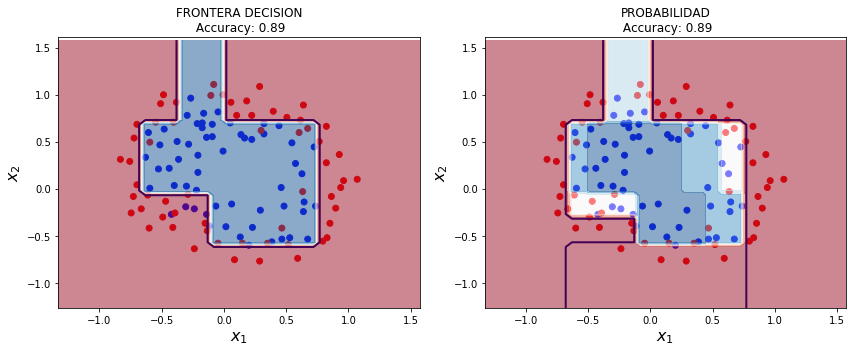

In [6]:
# Ejemplo 2
data2 = ejemplo2.values
X2 = data2[:,0:2]
y2 = data2[:,-1]

# creamos el modelo y ajustamos
tree_model_2 = DecisionTreeClassifier(min_samples_leaf=5, max_depth=25).fit(X2, y2)
plot_decision_boundary(X2, y2, 0.05, tree_model_2)

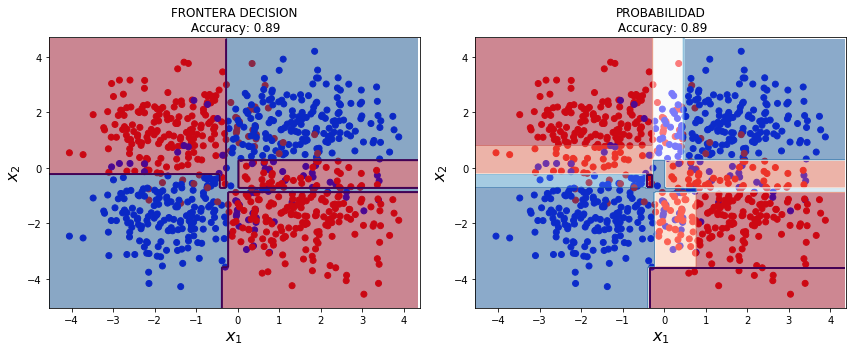

In [7]:
# Ejemplo 3
tree_model_3 = DecisionTreeClassifier(min_samples_leaf=1, max_depth=5).fit(X3, y3)
plot_decision_boundary(X3, y3, 0.05, tree_model_3)

A la vista de los ejemplos anteriores, podemos comentar varias cosas:

1) Seguramente estamos cometiendo overfitting, porque las fronteras de separación son altamente complejas, ¿cómo podemos controlar la complejidad de un árbol?

Los modelos basados en árboles tienen varios parámetros para controlar la complejidad del mismo (véase la [documentación](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), por ejemplo). Normalmente, los parámetros más relevantes para controlar la complejidad son:

* **profundidad** del árbol (`max_depth`): Si utilizamos un árbol de profundidad 1, sólo podremos dividir el espacio en dos (una decisión). Si utilizamos un árbol de profundidad 2, tomaremos 4 decisiones, y así sucesivamente. Por tanto, con la profundidad controlamos la complejidad del árbol de decisión, y este parámetro sirve como herramienta para **regularizar* el algoritmo:

    - Un árbol de poca profundidad (poco complejo), tendrá menor riesgo de sufrir overfitting a cambio de, potencialmente, incurrir en más error de clasificación.

    - Un árbol de mucha profundidad (muy complejo), tendrá mayor riesgo de sufrir overfitting a cambio de, potencialmente, mejorar el error de clasificación.

* **Número mínimo de muestras en una hoja** (`min_samples_leaf`). Podemos forzar a que una hoja tenga un número mínimo de muestras en cada hoja, de tal forma que:
    - Un árbol con un `min_samples_leaf` elevado, tendrá complejidad menor que un árbol con `min_samples_leaf pequeño.

2) Las prestaciones las estamos midiendo sobre el conjunto de entrenamiento. Hasta que no comparemos estas prestaciones con las obtenidas en un conjunto de prueba, no sabremos el alcance real del sobreajuste.

#### Ejercicio interactivo
Sobre los ejemplos anteriores varía los parámetros `max_depth` y `min_samples_leaf` (primero de forma individual y después conjuntamente) y comprueba el resultado, ¿coincide con tu intuición?

#### Ejercicio
Calcule el valor óptimo de `max_depth` para el ejemplo 3, ¿cuáles son las prestaciones del algoritmo para este ejemplo?

#### Solución

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Vamos a simular una situación real
# Primero, dividimos los datos en entrenamiento y test (75% training, 25% test)
# - Utilizaremos los datos de entrenamiento para entrenar y validar el modelo
# - Solo utilizaremos los datos de test para evaluar el funcionamiento final del algoritmo
X_train, X_test, y_train, y_test = train_test_split(X3, y3, 
                                                    stratify=y3, 
                                                    shuffle=True, 
                                                    test_size=0.25, 
                                                    random_state=2) # fijamos la semilla para garantizar la reproducibilidad

# Nos aseguramos de que la división se ha hecho correctamente
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([-1.,  1.]), array([300, 300], dtype=int64))
(array([-1.,  1.]), array([100, 100], dtype=int64))


best mean cross-validation score: 0.832
best parameters: {'max_depth': 5}


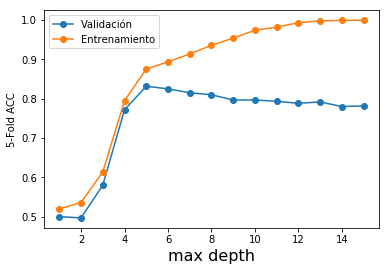

In [9]:
# SELECCIÓN DEL MODELO (model selection)
max_depth = np.arange(1, 16, 1) # rejilla de valores posibles que queremos explorar
param_grid = {'max_depth': max_depth}  


# Validaremos el modelo mediante validación cruzada en n_folds
n_folds = 5
grid = GridSearchCV(DecisionTreeClassifier(), 
                    scoring='accuracy', 
                    param_grid=param_grid, 
                    cv=5,
                    return_train_score=True)

grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores_test = np.array(grid.cv_results_['mean_test_score'])
scores_train = np.array(grid.cv_results_['mean_train_score'])
plt.plot(max_depth, scores_test, '-o', label='Validación')
plt.plot(max_depth, scores_train, '-o', label='Entrenamiento')
plt.xlabel('max depth', fontsize=16)
plt.ylabel('{}-Fold ACC'.format(n_folds))
plt.legend(loc='best')
plt.show()

El procedimiento `GridSearchCV` ha seleccionado `max_depth=5` como el valor de parámetro óptimo. En la gráfica anterior podemos comprobar como, para ese valor, no existe uan diferencia sustancial entre la puntuación en entrenamiento y validación y, por tanto, no existe sobrejuste. Está claro como para valores superiores a 5, la puntuación en entrenamiento continúa mejorando mientras que la puntuación en validación se deteriora. Esto es una muestra clara, de que el modelo no generaliza adecuadamente a nuevos datos cuando el valor de `max_depth` es muy elevado.

In [10]:
# EVALUACIÓN DEL MODELO (model assessment)
max_depth_opt = grid.best_params_['max_depth']

dt = DecisionTreeClassifier(max_depth=max_depth_opt, random_state = 0)
dt.fit(X_train, y_train)

acc_train = dt.score(X_train, y_train)
acc_test  = dt.score(X_test, y_test)

print('Accuracy (train):', acc_train)
print('Accuracy (test): ', acc_test)


Accuracy (train): 0.85
Accuracy (test):  0.865


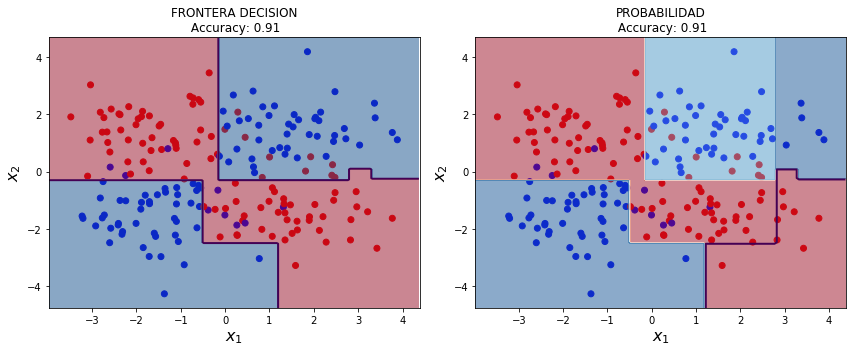

In [11]:
plot_decision_boundary(X_test, y_test, 0.05, dt)

## 2. Árboles de clasificación sobre ejemplo realista

Vamos a trabajar sobre un **problema de clasificación multiclase** de frutas a partir de sus propiedades. También abordaremos la visualización de un árbol de decisión.

In [12]:
fruits = pd.read_table('./data/fruit_data_with_colors.txt')
print(fruits.shape)

fruits.head(10)

(59, 7)


,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79
5,2,mandarin,mandarin,80,5.8,4.3,0.77
6,2,mandarin,mandarin,80,5.9,4.3,0.81
7,2,mandarin,mandarin,76,5.8,4.0,0.81
8,1,apple,braeburn,178,7.1,7.8,0.92
9,1,apple,braeburn,172,7.4,7.0,0.89


In [13]:
# creamos una correspondencia entre el código numérico de la fruta y su nombre para utilizarla en el futuro
lookup_fruit_name = {1: 'apple', 2: 'mandarin', 3: 'orange', 4: 'lemon'}

In [14]:
from sklearn.model_selection import train_test_split

# preparamos los datos:
# vamos a intentar predecir el tipo de fruta entre los cuatro tipos diferentes 
# a partir de su altura, anchura, masa y color
X = fruits[['height', 'width', 'mass', 'color_score']].as_matrix()
y = fruits['fruit_label'].as_matrix()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

print('Datos train: ', X_train.shape)
print('Datos test:  ', X_test.shape)

Datos train:  (47, 4)
Datos test:   (12, 4)


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# creamos el modelo y ajustamos
treeModel = DecisionTreeClassifier()
treeModel.fit(X_train, y_train)

y_test_predicted = treeModel.predict(X_test)
print(treeModel.score(X_test, y_test))

0.9166666666666666


### Visualizamos el árbol

In [16]:
import graphviz

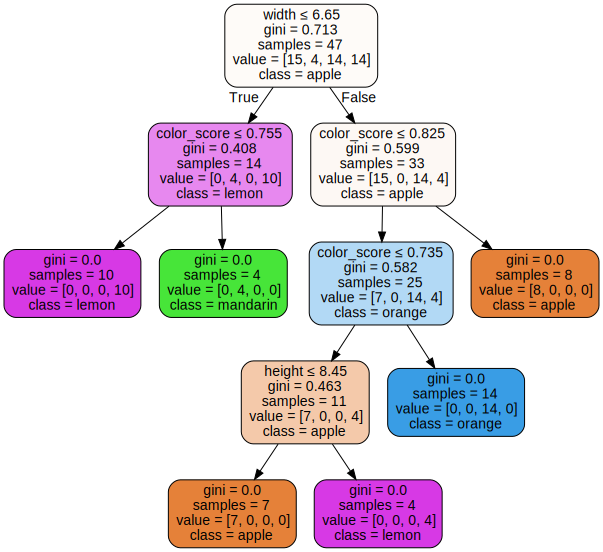

In [17]:
import graphviz

dot_data = tree.export_graphviz(treeModel, out_file=None, 
                         feature_names=['height', 'width', 'mass', 'color_score'],  
                         class_names=list(lookup_fruit_name.values()),  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data) 

graph

A la vista de la figura, observamos que:

1) Comenzamos con una impureza de Gini elevada (el valor máximo para este problema es 1-1/4=0.75) y a medida que aumentamos la profundidad la impureza diminuye, hasta que todas las hojas son puras (`gini=0.0`).

2) Es un árbol de profundidad 4.

3) Todas las muestras de entrenamiento están bien clasificadas.

4) Se realiza más de una división por la variable `color_score` en la misma rama.

In [18]:
features = ['height', 'width', 'mass', 'color_score']
test_sample = 3

print("La muestra de test con etiqueta '{}' y atributos:".format(lookup_fruit_name[y_test[test_sample]]))
for i, f in enumerate(features):
    print('- {}: {}'.format(f, X_test[test_sample,i]))
print("ha sido clasificada como: '{}' ".format(lookup_fruit_name[y_test_predicted[test_sample]]))

La muestra de test con etiqueta 'orange' y atributos:
- height: 7.1
- width: 6.7
- mass: 140.0
- color_score: 0.72
ha sido clasificada como: 'apple' 


#### Ejercicio interactivo
Para el ejemplo de la celda anterior, ¿puedes seguir el camino de la decisión?

## 3. Árboles de regresión

Vamos a aplicar árboles de regresión sobre nuestro ejemplo de regresión sintético:

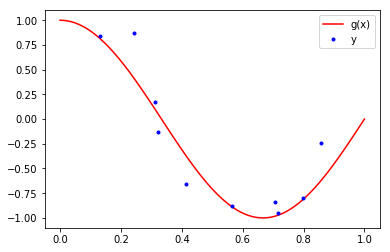

In [19]:
# Generamos los datos
N_train = 10
N_test  = 100

# función verdadera g(x)
x = np.linspace(0,1,N_test)
g_x = np.cos(1.5*np.pi*x)

# proceso y
np.random.seed(0) # para asegurar reproducibilidad
epsilon = np.random.randn(N_test) * 0.2
y = g_x + epsilon

# Datos: D = {x_i,y_i}, obtenemos una muestra
idx = np.random.randint(0,N_test,N_train)
x_i = x[idx]
y_i = y[idx]

# Dibujamos la función g(x), y el conjunto de datos x_i,y_i
plt.plot(x,g_x,'r',label='g(x)')
plt.plot(x_i,y_i,'b.',label='y')
plt.legend()
plt.show()

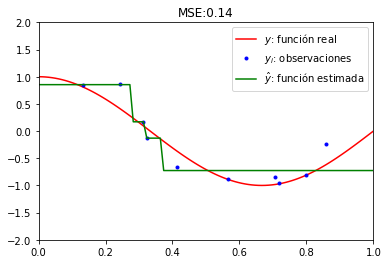

In [20]:
from sklearn.tree import DecisionTreeRegressor

X_train = x_i.reshape(-1, 1)
y_train = y_i
X_test  = x.reshape(-1, 1)

reg_tree = DecisionTreeRegressor(max_depth=2)
reg_tree.fit(X_train, y_train)

y_hat = reg_tree.predict(X_test)

# error
error_test = np.mean(np.power(y - y_hat,2)) 

plt.plot(x, g_x, 'r', label='$y$: función real')
plt.plot(x_i, y_i, 'b.', label='$y_i$: observaciones')
plt.plot(x, y_hat, 'g', label='$\hat{y}$: función estimada')
plt.title('MSE:%.2f' % error_test)
plt.legend()
plt.xlim((0, 1))
plt.ylim((-2, 2))
plt.show()

### Ejercicio interactivo
Modifica los valores de `max_depth` y observa el resultado, ¿concuerda con tu intuición?

### Ejercicio
Representa el árbol entrenado

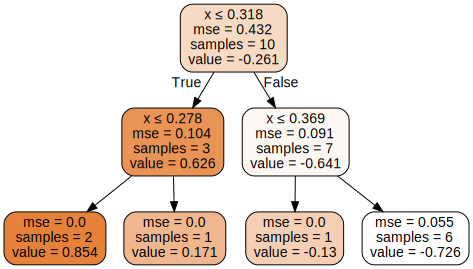

In [21]:
dot_data = tree.export_graphviz(reg_tree, out_file=None, 
                         feature_names=['x'],  
                         filled=True, rounded=True,  
                         special_characters=True)
graph = graphviz.Source(dot_data) 

graph